- https://realpython.com/generative-adversarial-networks/
- https://proglib.io/p/generativno-sostyazatelnaya-neyroset-vasha-pervaya-gan-model-na-pytorch-2020-08-11

In [1]:
import torch
from torch import nn

In [2]:
import math
import matplotlib.pyplot as plt

In [3]:
import torchvision
import torchvision.transforms as transforms

In [4]:
torch.manual_seed(111)

In [5]:
torch.__version__

'2.5.0+cu124'

In [6]:
device = None

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [7]:
device

device(type='cuda')

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [9]:
transform

Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

In [10]:
train_set = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)

In [11]:
train_loader_batch_size=64

In [12]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_loader_batch_size, shuffle=True)

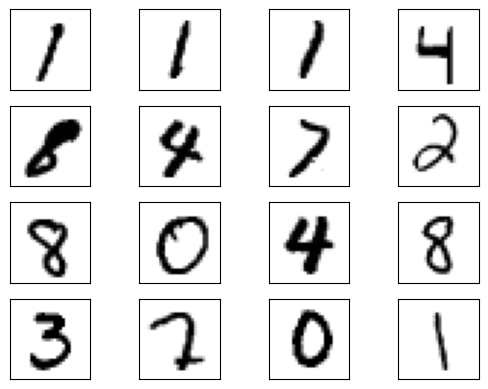

In [13]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [14]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
    
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [15]:
latent_size = 8

In [16]:
discriminator = Discriminator().to(device=device)

In [17]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(latent_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [18]:
generator = Generator().to(device=device)

In [19]:
lr = 0.0001 * 2.0

In [20]:
num_epochs = 100

In [21]:
loss_function = nn.BCELoss()

In [22]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)

In [23]:
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [24]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        batch_size = len(real_samples)
        
        # the real digit samples with label "1"
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)

        # random input vectors for the generator
        latent_space_samples = torch.randn((batch_size, latent_size)).to(device=device)

        # generated samples with label "0"
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)

        # combine the real samples and the generated samples into the single set
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # train the disriminator on the combined samples
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # random input vectors for the generator
        latent_space_samples = torch.randn((batch_size, latent_size)).to(device=device)

        # train the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

    # show loss
    print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
    print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.041943471878767014
Epoch: 0 Loss G.: 4.230138778686523
Epoch: 1 Loss D.: 0.05290652811527252
Epoch: 1 Loss G.: 3.5272181034088135
Epoch: 2 Loss D.: 0.1690281331539154
Epoch: 2 Loss G.: 3.376920700073242
Epoch: 3 Loss D.: 0.0757203996181488
Epoch: 3 Loss G.: 4.633210182189941
Epoch: 4 Loss D.: 0.041191648691892624
Epoch: 4 Loss G.: 3.893087387084961
Epoch: 5 Loss D.: 0.09884363412857056
Epoch: 5 Loss G.: 3.3230185508728027
Epoch: 6 Loss D.: 0.10977160930633545
Epoch: 6 Loss G.: 4.745662212371826
Epoch: 7 Loss D.: 0.046731676906347275
Epoch: 7 Loss G.: 4.064044952392578
Epoch: 8 Loss D.: 0.09839572012424469
Epoch: 8 Loss G.: 2.9680960178375244
Epoch: 9 Loss D.: 0.015530353412032127
Epoch: 9 Loss G.: 4.9772491455078125
Epoch: 10 Loss D.: 0.005306381732225418
Epoch: 10 Loss G.: 8.404178619384766
Epoch: 11 Loss D.: 0.1457064300775528
Epoch: 11 Loss G.: 3.8075318336486816
Epoch: 12 Loss D.: 0.2119804471731186
Epoch: 12 Loss G.: 3.476555824279785
Epoch: 13 Loss D.: 0.16542

In [25]:
latent_space_samples = torch.randn(16, latent_size).to(device=device)

In [26]:
generated_samples = generator(latent_space_samples)

In [27]:
generated_samples.grad_fn

In [28]:
generated_samples = generated_samples.cpu().detach()

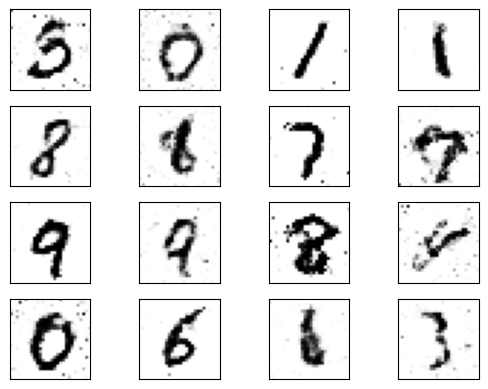

In [29]:
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])